**Load and mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import libraries**

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

**Root directory of the project**

In [ ]:
%cd "/content/drive/MyDrive/"

/content/drive/MyDrive


**Clone the Mask-RCNN Repository**

In [ ]:
%cd "/content/drive/MyDrive//"
!git clone https://github.com/leekunhee/Mask_RCNN.git

/content/drive/MyDrive
fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


**Setting model.py file flag for GPU utilization**

Find model.py file, Go to line 2362, Set workers = 1

In [ ]:
import os
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Mask_RCNN")
%cd "/content/drive/MyDrive/Mask_RCNN/"
!pip uninstall mask_rcnn -y
!python setup.py install

/content/drive/MyDrive/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest tem

**Set custom configuration for training and imports**

In [ ]:
sys.path.append(ROOT_DIR)   # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5") # Path to trained weights file

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs") # Directory to save logs and model checkpoints

class CustomConfig(Config):
    NAME = "food"
    IMAGES_PER_GPU = 2 # Adjust down if you use a smaller GPU.
    NUM_CLASSES = 1 + 4  # Background + (Horse and Man) Background is always 1 + number of classes
    STEPS_PER_EPOCH = 100     # Number of training steps per epoch
    DETECTION_MIN_CONFIDENCE = 0.9     # Skip detections with < 90% confidence why?
                                      #explantion https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d

**Set CustomDataset Class**

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have four class to add.
        self.add_class("food", 1, "bread")
        self.add_class("food", 2, "beef")
        self.add_class("food", 3, "cheese")
        self.add_class("food", 4, "tomato")

        # self.add_class("object", 3, "xyz") #likewise

        assert subset in ["train", "val"] # Train or validation dataset
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        annotations = list(annotations1.values())  
     
        annotations = [a for a in annotations if a['regions']]
        
         # Add images
        for a in annotations:
      
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            name_dict = {"bread": 1,"beef": 2, "cheese": 3,"tomato": 4} #,"xyz": 3}
            num_ids = [name_dict[a] for a in objects]
     
       
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "food", 
                image_id=a['filename'],  
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        """

        # If not a tomato/bread dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "food":
            return super(self.__class__, self).load_mask(image_id)
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "food":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # four classed ID, we return an array of 4s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "food":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
def train(model):
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom(os.path.join(ROOT_DIR,"dataset"), "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom(os.path.join(ROOT_DIR, "dataset"),"val")
    dataset_val.prepare()
    
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

**Checking GPU**

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

**Start Training**

In [ ]:
train(model)

numids [1, 2, 3]
numids [4, 1, 4, 1]
numids [1, 2, 3]
numids [4, 1, 4, 1]
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Mask_RCNN/logs/food20210716T0753/mask_rcnn_food_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)

KeyboardInterrupt: ignored

**Import Mask RCNN**

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

**Directory to save logs and trained model**

In [ ]:
sys.path.append(ROOT_DIR)   # To find local version
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
%matplotlib inline
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


 **Set Configuration for validation**

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the CocoConfig class in coco.py.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the CocoConfig class and override the attributes you need to change.

You can change your own setting here in our case we have 4 classes for vehicle case

In [ ]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "dataset")
class InferenceConfig(config.__class__):
  # Set batch size to 1 since we'll be running inference on
  # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
  GPU_COUNT = 1 
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.7
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

**Load validation dataset**

In [ ]:
CUSTOM_DIR = os.path.join(ROOT_DIR,"dataset")
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names)) #You should see number of classes

numids [1, 2, 3]
numids [4, 1, 4, 1]
Images: 2
Classes: ['BG', 'bread', 'beef', 'cheese', 'tomato']


**Load model**


In [ ]:
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

**Load the last model you trained**

In [ ]:
WEIGHTS_PATH = os.path.join("/content/drive/MyDrive/Mask_RCNN/logs/food20210716T0753/mask_rcnn_food_0002.h5")  # TODO: update this path
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/MyDrive/Mask_RCNN/logs/food20210716T0753/mask_rcnn_food_0002.h5
Re-starting from epoch 2


**Run detection**

image ID: food.8.jpg (0) /content/drive/MyDrive/Mask_RCNN/dataset/val/8.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:  220.00000  max:  832.00000  int32
gt_mask                  shape: (56, 56, 3)           min:    0.00000  max:    1.00000  bool


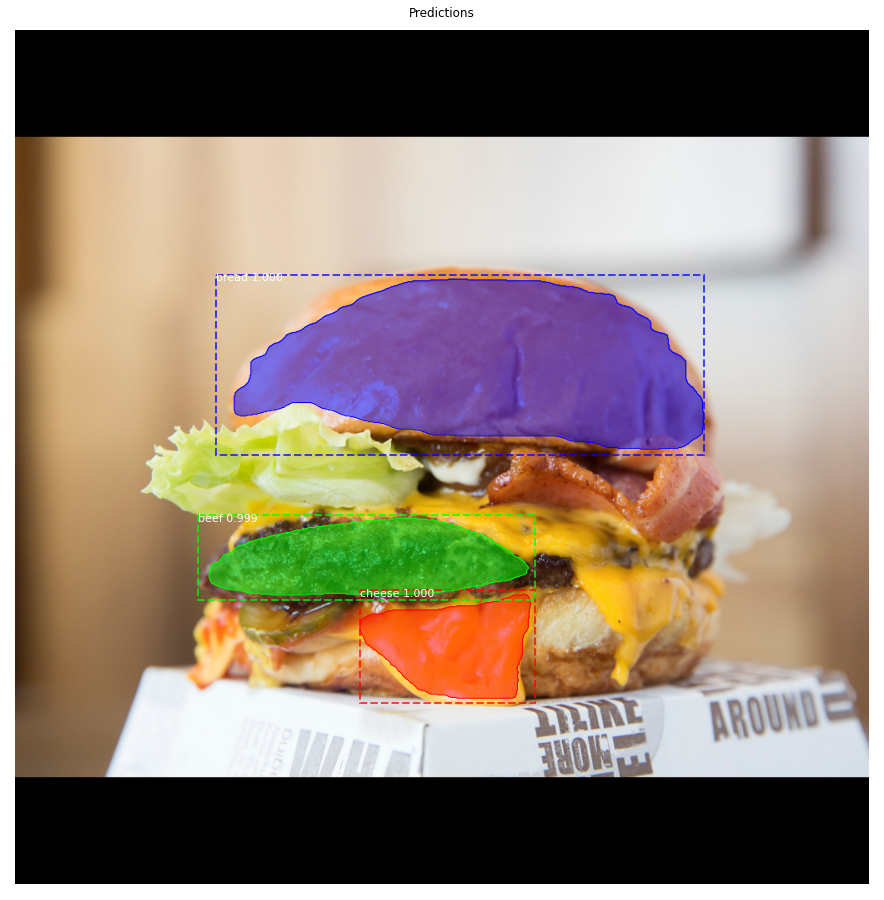

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
results = model.detect([image], verbose=1) # Run object detection

ax = get_ax(1) # Display results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

**References**

1. https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d

2. https://github.com/matterport/Mask_RCNN/issues/372

3. https://github.com/leekunhee/Mask_RCNN
